In [6]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import matplotlib as mpl   
import matplotlib.pyplot as plt
import time
import random
from tqdm import tqdm
%matplotlib inline
from numpy.random import multivariate_normal as randN


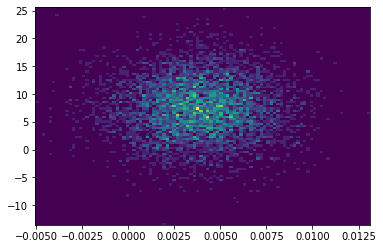

In [11]:
def gen_mog_pupulation(side_len, std, spread=3, num_points=5000):
    # num_points 2D datapoints for each gaussian
    temp = np.zeros((num_points*side_len*side_len, 2))
    for i in range(side_len):
        for j in range(side_len):
            temp[(i*side_len + j)*num_points:(i*side_len + j + 1)*num_points,:] = np.random.normal(((i+0.5)*std*spread,(j+0.5)*std*spread), std, (num_points,2))
    return temp
data1 = gen_mog_pupulation(1, 5)
data1[:,0] = data1[:,0]/2000
plt.hist2d(data1[:,0], data1[:,1], bins=100)
plt.show()

In [2]:
def gen_fast_mog_posterior(side_len, cov, spread=3):
    # Always centered at (0,0)
    # Only odd side_len supported
    diameter = cov[0,0]*spread
    
    def log_posterior(x, data):
        center = np.floor(x/diameter)*diameter
        gridsize = 3
        res = 0
        for i in range(gridsize):
            for j in range(gridsize):
                mean = np.array([center[0] + (i + 0.5 - gridsize/2)*std*spread, center[1] + (j + 0.5 - gridsize/2)*std*spread])
                res += np.exp(-0.5*(x-mean).T@np.linalg.inv(cov)@(x-mean))/np.sqrt(2*(np.pi**2)*np.linalg.det(cov))
                
        if np.amax(np.abs(x)) - 0.5*diameter > diameter*np.floor(side_len*0.5):
            return -100000
        
        return np.log(res)
    
    return log_posterior

def gen_fast_ndim_mog_posterior(side_len, cov, dim=2, spread=3):
    # Always centered at (0,0)
    # Only odd side_len supported
    diameter = cov[0,0]*spread
    
    def log_posterior(x, data):
        center = np.floor(x/diameter)*diameter
        gridsize = 1
        res = 0
        
        temp = np.ones((gridsize,)*dim, dtype=np.float32)
        iter = np.nditer(temp, flags=['multi_index'])

        for it in iter:
            mean = []
            for j in range(gridsize):
                mean.append(center[j] + (iter.multi_index[j] + 0.5 - gridsize/2)*std*spread)
            res += np.exp(-0.5*(x-mean).T@np.linalg.inv(cov)@(x-mean))/np.sqrt(2*(np.pi**2)*np.linalg.det(cov))

        if np.amax(np.abs(x)) - 0.5*diameter > diameter*np.floor(side_len*0.5):
            return -100000
        
        return np.log(res)
    
    return log_posterior

In [3]:
std = 5
dim = 32  # Highest dim number allowed is 32
cov = np.identity(dim, dtype=np.float32) * std

log_pos = gen_fast_ndim_mog_posterior(5, cov, dim)
log_pos(np.zeros(dim), 1)

-27.242310091665654

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]<ipython-input-19-d9c4e502737d>:9: RuntimeWarning: overflow encountered in exp
  acc_ratio = np.exp(x_new-x)
<ipython-input-2-1bb15e4dcc8e>:44: RuntimeWarning: divide by zero encountered in log
  return np.log(res)
100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:44<00:00, 2226.43it/s]


Density of the samples:


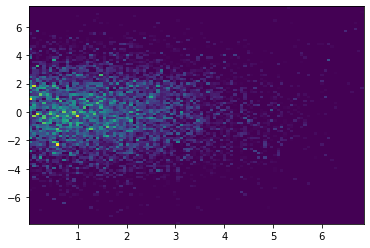

Average acceptance ratio is: 0.20332


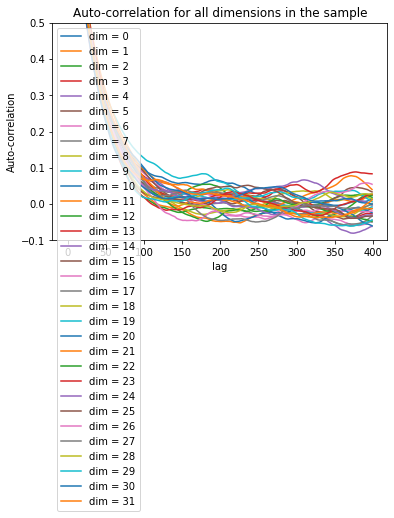

histogram along dim 0:


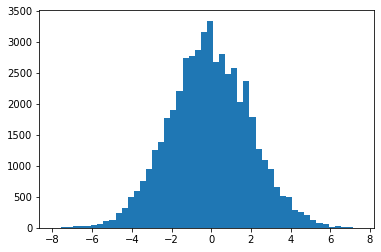

histogram along dim 1:


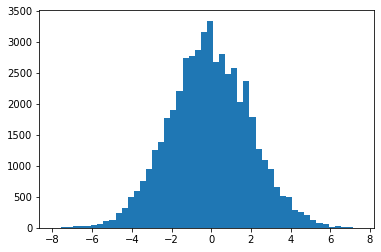

In [19]:
def prior(params):
    return 1

#Defines whether to accept or reject the new sample
def acceptance(log_pi, log_pi_new, proposal_ratio=1):
    accept=np.random.uniform(0,1)
    # Since we did a log likelihood, we need to exponentiate in order to compare to the random number
    # less likely x_new are less likely to be accepted
    acc_ratio = np.exp(log_pi_new-log_pi)*proposal_ratio
    sig = 0
    if accept < acc_ratio:
        sig = 1
    if acc_ratio > 1:
        acc_ratio = 1
    return sig, acc_ratio

# compute autocorrelation at dimension dim
def autocorrelation(samples, dim, max_lag):
    x_j = samples[:, dim]
    tmp = x_j - np.mean(x_j)
    C_0 = np.sum(tmp**2)
    auto_correlation = np.correlate(tmp, tmp, "same")
    auto_correlation = auto_correlation / C_0
    # auto correlation is symmetric
    init = int((len(auto_correlation)/2))
    return auto_correlation[init:init+max_lag]
 
# plot autocorrelation 
def plot_autocorr(samples, max_lag=200, y_max = 0.2, y_min = -0.1):
    n, d = samples.shape
    for dim in range(d):
        A = autocorrelation(samples, dim, max_lag)
        label_dim = "dim = " + str(dim)
        plt.plot(A, label=label_dim)
    plt.title('Auto-correlation for all dimensions in the sample')    
    plt.xlabel('lag')
    plt.ylim((y_min, y_max))
    plt.ylabel('Auto-correlation')
    plt.legend()
    plt.show()
    return

def update_global_AM(optim_acc, t, acc_t, x, eps, lam, mu, sigma):
    gamma   = 1 / (1 + t)**eps
    new_lam = np.exp(gamma*(acc_t - optim_acc)) * lam
    tmp = np.array(x) - mu
    new_mu  = mu + gamma*tmp
    new_sigma = sigma + gamma * (np.outer(tmp, tmp) - sigma)
    return  new_lam, new_mu, new_sigma

def Global_AM(likelihood_computer, prior, x_init, iterations, burn_in,
              data, acceptance_rule, eps = 0.75, optim_acc = 0.234):
    x = x_init
    d = len(x_init)
    samples = []; accepted = []
    # initialize lambda to be the optimal scaling for SRWN
    lam = 2.38**2/d 
    # initialize covariance sigma to be a small diagonal matrix
    sigma = np.identity(d)
    # mu is initialize to be a small value to avoid underflow
    mu = 1e-4 * np.ones(d)
    accept_acc = 0
    for i in tqdm(range(iterations)):
        x_new = randN(x, lam * sigma)
        x_lik = likelihood_computer(np.array(x), data)
        x_new_lik = likelihood_computer(np.array(x_new), data)
        # MH step
        sig, acc_ratio = acceptance_rule(x_lik + np.log(prior(x)),x_new_lik+np.log(prior(x_new)))
        if sig:            
            x = x_new
        if i >= burn_in:
            samples.append(x)
            if sig == 1:
                accept_acc += 1
        lam, mu, sigma = update_global_AM(optim_acc, i, acc_ratio, x, eps, lam, mu, sigma)
        # report all the accepted states as well
        accepted.append(x)
    # average acceptance ratio
    avg_acc = accept_acc / (iterations - burn_in)
    return np.array(samples), avg_acc, np.array(accepted)

samples_GAM, avg_acc, accepted_GAM = Global_AM(log_pos, prior, 100*np.ones(32), 100000, 50000, data1, acceptance)
print("Density of the samples:")
plt.hist2d(samples_GAM[:,0], samples_GAM[:,1], bins=100)
plt.show()
print("Average acceptance ratio is:", avg_acc)
plot_autocorr(samples_GAM, max_lag=400, y_max = 0.5, y_min = -0.1)
print("histogram along dim 0:")
plt.hist(samples_GAM[:,1], bins=50)
plt.show()
print("histogram along dim 1:")
plt.hist(samples_GAM[:,1], bins=50)
plt.show()